In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from glob import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotx
import numpy as np
import pandas as pd
import seaborn as sns
from fastcore.xtras import load_pickle
from guacamol.utils.chemistry import is_valid
from scipy.stats import sem

from gptchem.data import get_polymer_data
from gptchem.evaluator import (
    evaluate_generated_smiles,
    evaluate_photoswitch_smiles_pred,
    get_continuos_binned_distance,
)
from gptchem.formatter import InverseDesignFormatter
from gptchem.plotsettings import *
from gptchem.settings import ONE_COL_GOLDEN_RATIO_HEIGHT_INCH, ONE_COL_WIDTH_INCH

%matplotlib inline

In [3]:
data = get_polymer_data()

formatter = InverseDesignFormatter(
    representation_column="string",
    property_columns=["deltaGmin"],
    property_names=["adsorption_energy"],
    num_classes=5,
)
formatted = formatter(data)

In [4]:
all_res = glob("out/**/*.pkl")

In [5]:
res = load_pickle(all_res[0])

In [6]:
temperatures = [0.0, 0.1, 0.2, 0.5, 0.75, 1.0, 1.25, 1.5]

In [7]:
from more_itertools import pairwise

In [8]:
compiled_res = []

for filename in all_res:
    loaded = load_pickle(filename)
    try:
        for i, res in enumerate(loaded["res"]):
            preds = [r["prediction"][0] for r in res["predictions"]]
            mapes = [
                get_continuos_binned_distance(pred, expected, bins=list(pairwise(formatter.bins)))
                / pred
                for pred, expected in zip(preds, res["expected_performance"])
            ]
            result = {
                "num_train_points": loaded["num_train_points"],
                "noise_level": loaded["noise_level"],
                "valid_fraction": res["valid_smiles_fraction"],
                "unique_fraction": res["unique_smiles_fraction"],
                "temp": temperatures[i],
                "kldiv_score": res["kldiv_score"],
                "mae": np.mean(res["losses"]),
                "mape": np.mean(np.abs(mapes) * 100),
                **res["string_distances_collection_summary"],
            }
            for k, v in res["summary_composition_mismatches"].items():
                result[f"comp_mismatch_{k}"] = v

            compiled_res.append(result)
    except Exception as e:
        print(e)
        pass

In [9]:
df = pd.DataFrame(compiled_res)

In [10]:
grouped = df.groupby(["num_train_points", "temp"]).agg(["mean", "std", sem])

In [11]:
grouped["mape"]

mean       std       sem
num_train_points temp                               
100              0.00  26.839484  8.202309  3.668184
                 0.10  27.244360  6.646949  2.972606
                 0.20  22.422610  3.664763  1.638932
                 0.50  22.356414  4.438854  1.985116
                 0.75  24.466894  2.660182  1.189670
                 1.00  24.046377  2.001104  0.894921
                 1.25  26.001722  1.654134  0.739751

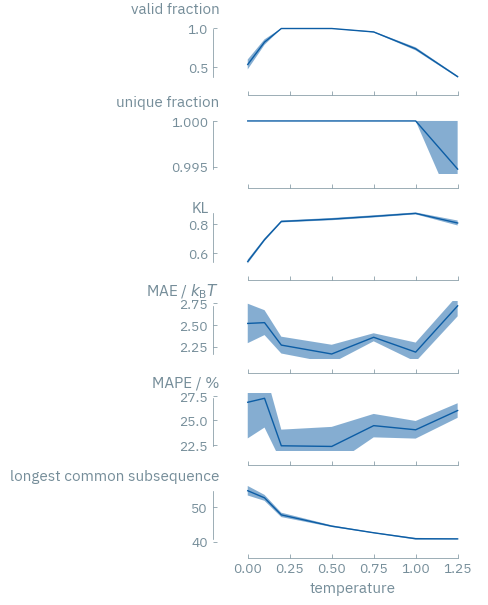

In [12]:
fig, ax = plt.subplots(6, 1, sharex="all", figsize=(ONE_COL_WIDTH_INCH, 2 * ONE_COL_WIDTH_INCH))

ax[0].plot(grouped.loc[100, :].index, grouped.loc[100, :]["valid_fraction"]["mean"])
ax[0].fill_between(
    grouped.loc[100, :].index,
    grouped.loc[100, :]["valid_fraction"]["mean"] - grouped.loc[100, :]["valid_fraction"]["sem"],
    grouped.loc[100, :]["valid_fraction"]["mean"] + grouped.loc[100, :]["valid_fraction"]["sem"],
    alpha=0.5,
)
ylabel_top("valid fraction", ax=ax[0])

range_frame(
    ax[0],
    grouped.loc[100, :].index,
    np.nan_to_num(
        np.stack(
            [
                grouped.loc[100, :]["valid_fraction"]["mean"],
                grouped.loc[100, :]["valid_fraction"]["mean"],
            ]
        ).flatten(),
        grouped.loc[100, :]["valid_fraction"]["mean"].mean(),
    ),
)

ax[1].plot(grouped.loc[100, :].index, grouped.loc[100, :]["unique_fraction"]["mean"])
ax[1].fill_between(
    grouped.loc[100, :].index,
    grouped.loc[100, :]["unique_fraction"]["mean"] - grouped.loc[100, :]["unique_fraction"]["sem"],
    grouped.loc[100, :]["unique_fraction"]["mean"] + grouped.loc[100, :]["unique_fraction"]["sem"],
    alpha=0.5,
)
ylabel_top("unique fraction", ax=ax[1])


range_frame(
    ax[1],
    grouped.loc[100, :].index,
    np.nan_to_num(
        np.stack(
            [
                grouped.loc[100, :]["unique_fraction"]["mean"],
                grouped.loc[100, :]["unique_fraction"]["mean"],
            ]
        ).flatten(),
        grouped.loc[100, :]["unique_fraction"]["mean"].mean(),
    ),
)


ax[2].plot(grouped.loc[100, :].index, grouped.loc[100, :]["kldiv_score"]["mean"])
ax[2].fill_between(
    grouped.loc[100, :].index,
    grouped.loc[100, :]["kldiv_score"]["mean"] - grouped.loc[100, :]["kldiv_score"]["sem"],
    grouped.loc[100, :]["kldiv_score"]["mean"] + grouped.loc[100, :]["kldiv_score"]["sem"],
    alpha=0.5,
)
ylabel_top("KL", ax=ax[2], x_pad=0.05)


range_frame(
    ax[2],
    grouped.loc[100, :].index,
    np.nan_to_num(
        np.stack(
            [grouped.loc[100, :]["kldiv_score"]["mean"], grouped.loc[100, :]["kldiv_score"]["mean"]]
        ).flatten(),
        grouped.loc[100, :]["kldiv_score"]["mean"].mean(),
    ),
)


ax[3].plot(grouped.loc[100, :].index, grouped.loc[100, :]["mae"]["mean"])
ax[3].fill_between(
    grouped.loc[100, :].index,
    grouped.loc[100, :]["mae"]["mean"] - grouped.loc[100, :]["mae"]["sem"],
    grouped.loc[100, :]["mae"]["mean"] + grouped.loc[100, :]["mae"]["sem"],
    alpha=0.5,
)
ylabel_top("MAE / $k_\mathrm{B}T$", ax=ax[3])

range_frame(
    ax[3],
    grouped.loc[100, :].index,
    np.nan_to_num(
        np.stack(
            [grouped.loc[100, :]["mae"]["mean"], grouped.loc[100, :]["mae"]["mean"]]
        ).flatten(),
        grouped.loc[100, :]["mae"]["mean"].mean(),
    ),
)


ax[4].plot(grouped.loc[100, :].index, grouped.loc[100, :]["mape"]["mean"])
ax[4].fill_between(
    grouped.loc[100, :].index,
    grouped.loc[100, :]["mape"]["mean"] - grouped.loc[100, :]["mape"]["sem"],
    grouped.loc[100, :]["mape"]["mean"] + grouped.loc[100, :]["mape"]["sem"],
    alpha=0.5,
)
ylabel_top("MAPE / %", ax=ax[4])

range_frame(
    ax[4],
    grouped.loc[100, :].index,
    np.nan_to_num(
        np.stack(
            [grouped.loc[100, :]["mape"]["mean"], grouped.loc[100, :]["mape"]["mean"]]
        ).flatten(),
        grouped.loc[100, :]["mape"]["mean"].mean(),
    ),
)


ax[5].plot(grouped.loc[100, :].index, grouped.loc[100, :]["LongestCommonSubsequence_mean"]["mean"])
ax[5].fill_between(
    grouped.loc[100, :].index,
    grouped.loc[100, :]["LongestCommonSubsequence_mean"]["mean"]
    - grouped.loc[100, :]["LongestCommonSubsequence_mean"]["sem"],
    grouped.loc[100, :]["LongestCommonSubsequence_mean"]["mean"]
    + grouped.loc[100, :]["LongestCommonSubsequence_mean"]["sem"],
    alpha=0.5,
)
ylabel_top("longest common subsequence", ax=ax[5])


range_frame(
    ax[5],
    grouped.loc[100, :].index,
    np.nan_to_num(
        np.stack(
            [
                grouped.loc[100, :]["LongestCommonSubsequence_mean"]["mean"],
                grouped.loc[100, :]["LongestCommonSubsequence_mean"]["mean"],
            ]
        ).flatten(),
        grouped.loc[100, :]["LongestCommonSubsequence_mean"]["mean"].mean(),
    ),
)


ax[-1].set_xlabel("temperature", labelpad=4)
plt.subplots_adjust(hspace=0.6, top=1, bottom=0.2)
fig.savefig("random_binned_polymer_inverse.pdf", bbox_inches="tight")